# COVID19-EU

Statistics and Forecasting for the Coronavirus disease (COVID-19) in the European Union.

## Source of Data

 Johns Hopkins CSSE Repository: [https://github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19).

## Source of EU country names

Official website of the European Union: [https://europa.eu/european-union/about-eu/countries_en](https://europa.eu/european-union/about-eu/countries_en)

### Load libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
%matplotlib inline 

### Load Data from Johns Hopkins CSSE Repository

In [6]:
confirmed_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
fields = confirmed_data.keys()
confirmed = confirmed_data.loc[:, fields[4]:fields[-1]]

### EU Country Names

In [7]:
EU_Countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland',
'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

In [9]:
# Per day infections for a country (function)
def get_per_day_confirmed(confirmed, fields):
    days = []
    confirmed_per_day = []
    for i in confirmed.loc[:, fields[4]:fields[-1]]:
        days.append(i[0:-3])
        confirmed_per_day.append(confirmed[i].sum())
    #convert to numpy
    confirmed_per_day = np.array(confirmed_per_day).reshape(-1,1)
    return days, confirmed_per_day

In [10]:
# Per day infections for a country (instances)
confirmed_per_day_EU = []
confirmed_EU_sum = []
confirmed_week_forecast = []
for c in EU_Countries:
    confirmed = confirmed_data[confirmed_data['Country/Region'] == c]
    days, confirmed_per_day = get_per_day_confirmed (confirmed, fields)
    confirmed_EU_sum.append(int(confirmed_per_day.sum()))
    confirmed_per_day_EU.append(confirmed_per_day)

    data = confirmed_per_day.flatten()
    model = SARIMAX(data, trend='c', order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False, transparams=False)
    confirmed_week_forecast.append(model_fit.predict(len(data), len(data)+6, typ='levels'))

    # Sorted for visualization from most confirmed to less confirmed
confirmed_per_day_EU_idx = sorted(range(len(confirmed_EU_sum)), key=lambda k: confirmed_EU_sum[k])

### 10 Most infected EU countries

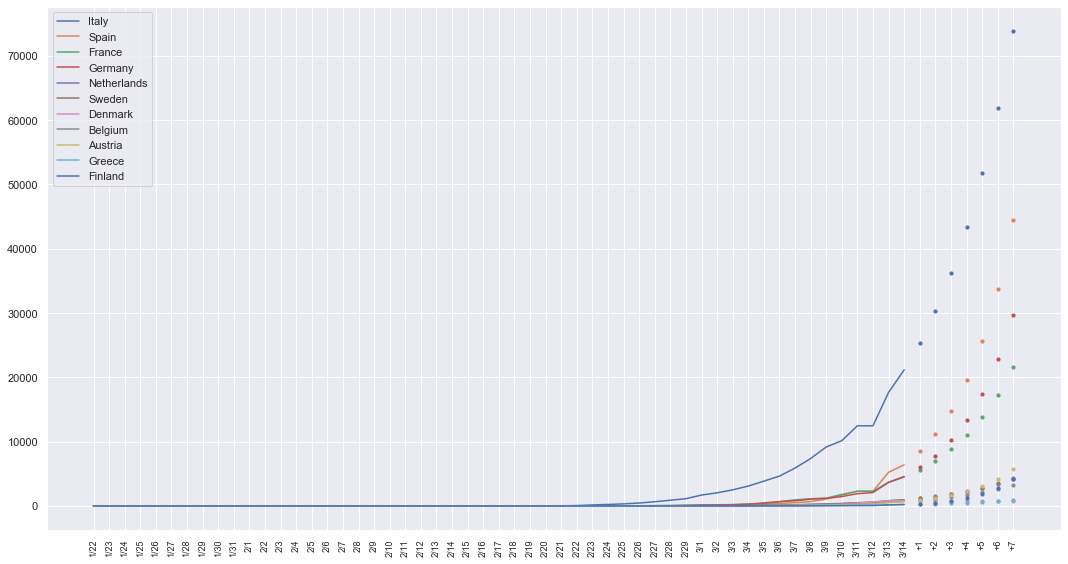

In [17]:
# forecasting days
days_with_forecast = ['+' + str(i+1) for i in range(confirmed_week_forecast[0].shape[0])]

sns.set()
plt.rcParams['figure.figsize'] = [15, 8]
for cnt, i in enumerate(reversed(confirmed_per_day_EU_idx)):
    plt.plot(days, confirmed_per_day_EU[i], label=EU_Countries[i])
    plt.scatter(days_with_forecast, confirmed_week_forecast[i], s=10, marker='o')

    if cnt == 10:
        break

plt.legend(loc='upper left')
plt.xticks(fontsize=9, rotation=90)
plt.tight_layout()

### All EU contries

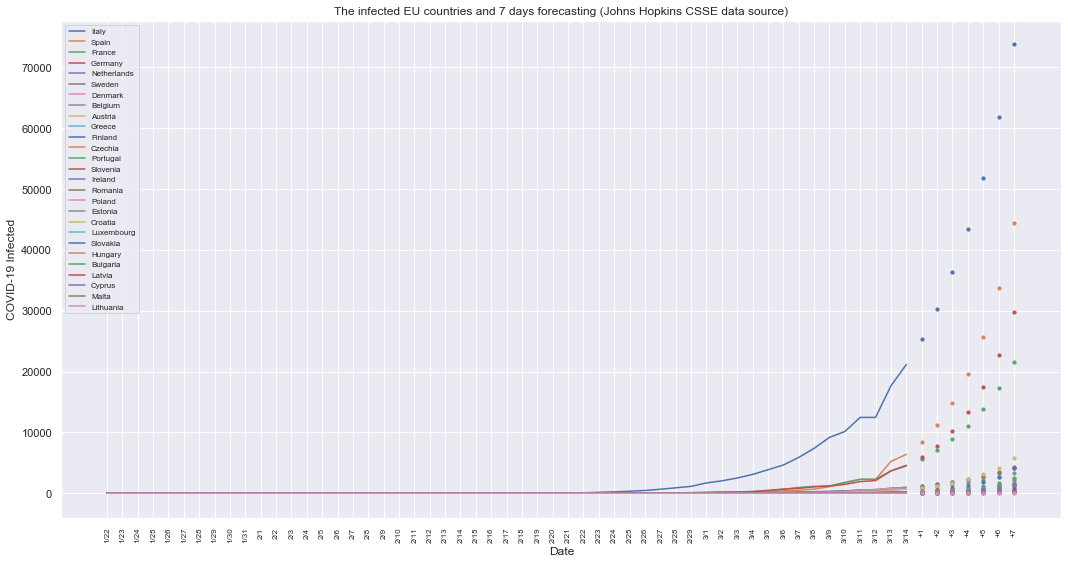

In [21]:
plt.rcParams['figure.figsize'] = [15, 8]
for cnt, i in enumerate(reversed(confirmed_per_day_EU_idx)):
    plt.plot(days, confirmed_per_day_EU[i], label=EU_Countries[i])
    plt.scatter(days_with_forecast, confirmed_week_forecast[i], s=10, marker='o')

plt.ylabel('COVID-19 Infected')
plt.xlabel('Date')
plt.title('The infected EU countries and 7 days forecasting (Johns Hopkins CSSE data source)')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(fontsize=8, rotation=90)
plt.tight_layout()
plt.show()